# Import Data

In [61]:
from __future__ import print_function
import keras
from keras.preprocessing import image
from keras.engine import Layer
from keras.layers import Conv2D, Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import numpy as np
from joblib import dump, load

In [62]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [56]:
from skimage.color import rgb2gray, lab2rgb

def ConvertToGreyscale(img):
    return rgb2gray(img)

In [71]:
from PIL import Image
import random

def importImages(path, extension, proportion = 1, normalize = None):
    from skimage.io import imread_collection
    collection = imread_collection(path + "/*" + extension)
    collection = collection[:: int(1/proportion)]
    if(normalize != None):
        print("normalizing")
        for im in collection:
            im = im / normalize
    return collection

def importImagesTF(path, proportion = 1, normalize = True): #TODO proportion
    
        if(normalize):
            datagen = ImageDataGenerator(rescale=1. / 255)
        else:
             datagen = ImageDataGenerator()
        return datagen.flow_from_directory(path,class_mode=None)
    

def importTestImages():
    return importImages(testImagePath, ".jpg", proportion = 0.05, normalize = None)


In [72]:
testImagePath = "utkcropped"

In [73]:
im_train = importImagesTF(testImagePath)

Found 0 images belonging to 0 classes.


In [67]:
from numpy.random import randint
from skimage import io
import matplotlib.pyplot as plt

def ViewImage(images, index = False):
    if(not index):
        index = randint(len(images))
    io.imshow(images[index])
    plt.show() 
    

In [16]:
images = importTestImages()
len(images)

1186

In [17]:
greyscaleImages = []
for im in images:
    greyscaleImages.append(ConvertToGreyscale(im)*255)

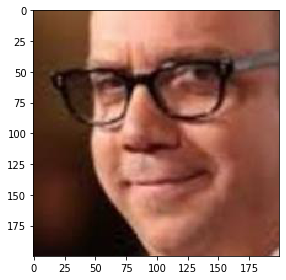

In [46]:
ViewImage(images)

X:\Core\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


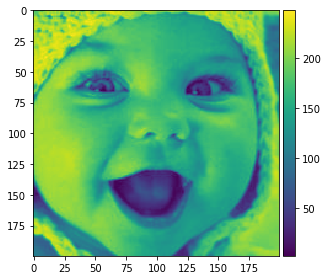

In [19]:
ViewImage(greyscaleImages)

In [20]:
shape = images[0].shape
print("Image shape:", shape)

Image shape: (200, 200, 3)


# Define Model

In [23]:
inputShape = (shape[0],shape[1],1) #1 color dimension for greyscale inputs. 
outputShape = shape 

In [24]:
#Number of epochs
n_epochs = 3

In [25]:
encoder_input = Input(shape=inputShape)


#Encoder
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=encoder_input, outputs=decoder_output)

## Tranform Data Shape

In [26]:
X = np.array(greyscaleImages) #may cause memory error, good luck. 

In [27]:
Y = np.array(images)

In [28]:
X = X.reshape(-1, inputShape[0], inputShape[1], inputShape[2])

In [29]:
X.shape

(1186, 200, 200, 1)

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [31]:
x_train.shape

(889, 200, 200, 1)

## Train Model

In [32]:
def BuildModel():
    model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
    model.fit(x = x_train,
              y = y_train,
              validation_split = 0.2, 
              epochs = n_epochs,
              verbose = 1)

In [33]:
force_retrain = True

model_name = "colorizor_model.joblib"


try:
    if force_retrain:
        raise Exception("retraining")
    model = load(model_name) 
    print("model loaded")

except:
    print("Model not found. Building new model. This may take quite some time...")
    BuildModel()
    dump(model, model_name) 

Model not found. Building new model. This may take quite some time...
Train on 711 samples, validate on 178 samples
Epoch 1/3
711/711 [==============================] - 174s 244ms/step - loss: 18620.4491 - accuracy: 0.8910 - val_loss: 19658.3616 - val_accuracy: 0.9287
Epoch 2/3
711/711 [==============================] - 174s 245ms/step - loss: 18611.8938 - accuracy: 0.9210 - val_loss: 19658.3616 - val_accuracy: 0.9287
Epoch 3/3
711/711 [==============================] - 172s 242ms/step - loss: 18611.8934 - accuracy: 0.9210 - val_loss: 19658.3616 - val_accuracy: 0.9287


In [40]:
def TestModel():
    index = randint(len(x_test))
    
    #recolored
    temp = np.array(x_test[[index]])
    pred = model.predict(temp)
    
    #original (color)
    original = y_test[index]
    
    #original (gray)
    temp2 = x_test[index]
    Gray = temp2.reshape(inputShape[0],inputShape[1])
    
    fig = plt.figure()
    
    fig.add_subplot(1,3, 1)
    plt.imshow(pred[0])
    
    fig.add_subplot(1,3, 2)
    plt.imshow(Gray, cmap = "gray")
    
    fig.add_subplot(1,3, 3)
    plt.imshow(original)
    
    plt.show()

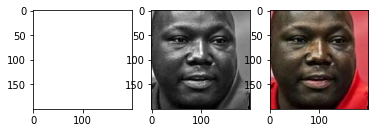

In [41]:
TestModel()

In [36]:
#TODO check keras is running on GPU (appears not to be, given the task manager info)

In [37]:
#TODO convert color images to 0-1, or greyscale to 0-255

In [42]:
images[0]

Array([[[147, 118,  78],
        [149, 120,  80],
        [151, 122,  82],
        ...,
        [196, 174, 127],
        [195, 173, 126],
        [196, 172, 126]],

       [[148, 119,  79],
        [149, 120,  80],
        [151, 122,  82],
        ...,
        [195, 173, 126],
        [195, 173, 126],
        [196, 172, 126]],

       [[148, 119,  77],
        [149, 120,  78],
        [151, 122,  80],
        ...,
        [194, 172, 125],
        [194, 172, 125],
        [195, 171, 125]],

       ...,

       [[170, 191, 218],
        [169, 190, 217],
        [169, 190, 217],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[169, 190, 217],
        [169, 190, 217],
        [167, 188, 215],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[169, 190, 217],
        [168, 190, 214],
        [166, 188, 212],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [43]:
greyscaleImages[0]

array([[121.2785, 123.2785, 125.2785, ..., 175.2863, 174.2863, 173.7834],
       [122.2785, 123.2785, 125.2785, ..., 174.2863, 174.2863, 173.7834],
       [122.1343, 123.1343, 125.1343, ..., 173.2863, 173.2863, 172.7834],
       ...,
       [188.4842, 187.4842, 187.4842, ...,   0.    ,   0.    ,   0.    ],
       [187.4842, 187.4842, 185.4842, ...,   0.    ,   0.    ,   0.    ],
       [187.4842, 187.0554, 185.0554, ...,   0.    ,   0.    ,   0.    ]])